In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime as dt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_prices(tickers_list, start, end, what_price):
    
    df = pd.DataFrame()
    for ticker in tickers_list:
        tmp = data.DataReader(ticker, 'yahoo', start, end)
        df[ticker] = tmp[what_price]
    return df 

In [3]:
tickers = ['SPY', 'IWM','TLT','EEM', 'IYR','LQD','TIP','GLD','OIH','FXE'] # 'JNK',, 'GSG'
st = dt.datetime(2011, 1, 1)
ed = dt.datetime(2016, 1, 1)

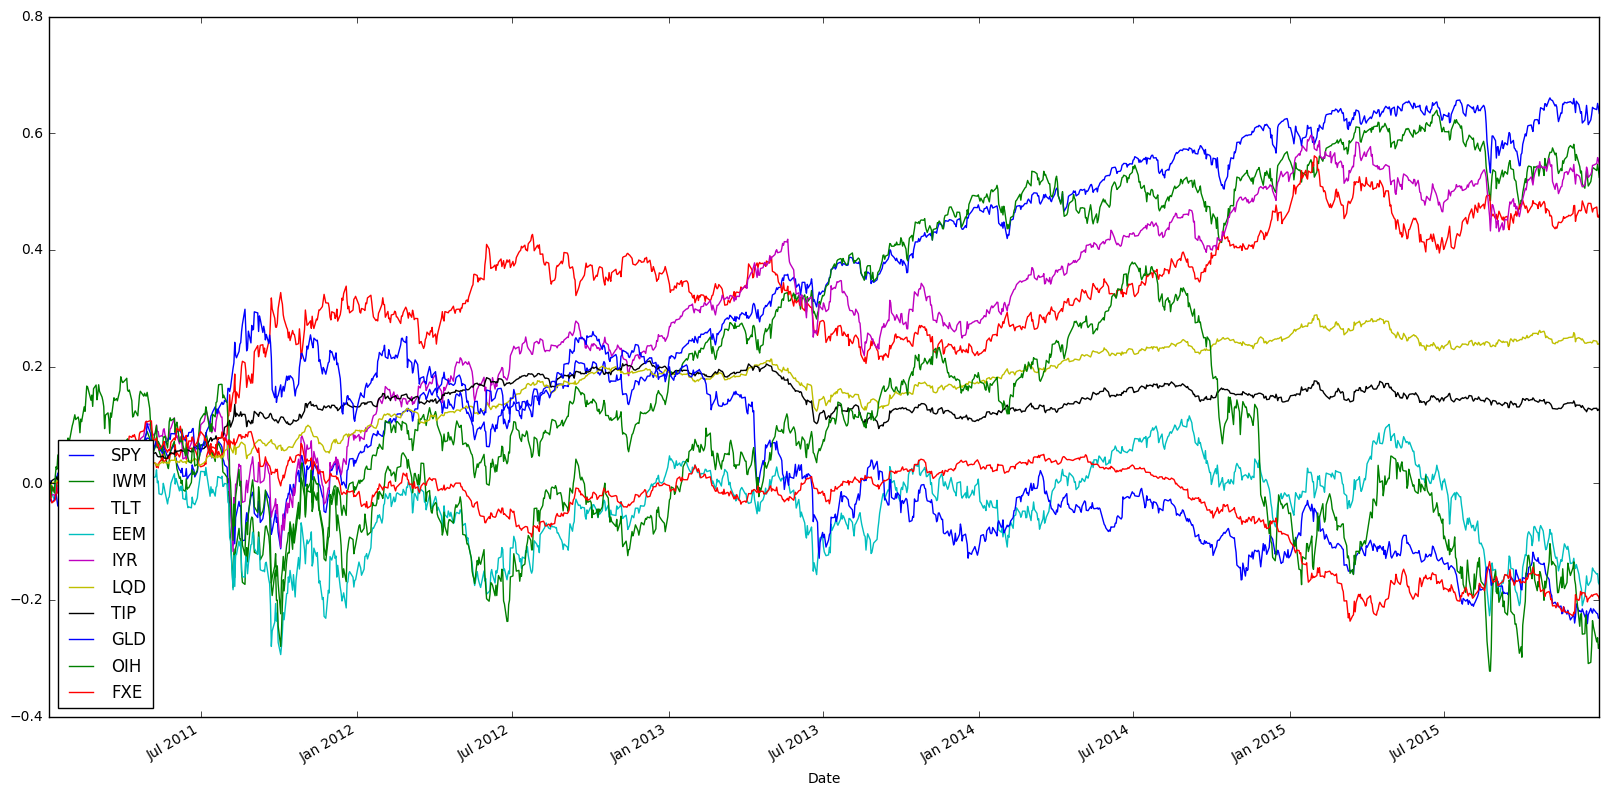

In [4]:
prices = get_prices(tickers, st, ed, 'Adj Close')
# Is pct_change good enough? Maybe make it ln(x2/x1)?
returns = prices.pct_change(1).dropna()
returns.cumsum().plot(figsize=(20,10))
plt.legend(loc=3)
plt.show()

In [5]:
horizon = [1, 2, 3, 5, 10, 20] #, 40, 60, 120, 250]
#Scores = pd.DataFrame(index=tickers, columns =[str(x)+' days' for x in horizon])
Scores_base  = pd.DataFrame(index=tickers, columns =[str(x)+' days' for x in horizon])
Scores_train = pd.DataFrame(index=tickers, columns =[str(x)+' days' for x in horizon])
Scores_test  = pd.DataFrame(index=tickers, columns =[str(x)+' days' for x in horizon])

In [68]:
### Object to do everything fast and simple

class x_y_creator(object):
    
    def __init__(self, n_fwd, tick, lags, day_of_week, month, first_friday):
        self.lags = lags
        self.dfw = day_of_week
        self.m = month
        self.ff = first_friday
        self.tick = tick
        self.n_fwd = n_fwd
        
    def data_feed(self, data):
        self.data = data
        return self
    
    def get_x(self):
        self.x = self.data.pct_change(self.n_fwd).dropna()
        self.x_base = self.x
        return self
    
    def get_lags(self):
        if self.lags != 0 and self.lags != None and self.lags > 0: 
            lagged_x = []
            for i in range(1,self.lags+1):
                name = 'Lag'+str(i)+'_'
                xl = self.x.shift(i)
                xl = xl.add_prefix(name)
                lagged_x.append(xl)
            
            xal = pd.concat(lagged_x, axis=1)
            self.x = self.x.join(xal).dropna().iloc[:-self.n_fwd]
            return self
        else:
            return self
        
    def get_dummies(self):
        if self.dfw == True:
            self.x['WeekDay'] = self.x.index.weekday_name
            self.x = pd.get_dummies(self.x)
            
        if self.m == True:
            self.x['Month'] = self.x.index.strftime('%b')
            self.x = pd.get_dummies(self.x)
            
        if self.ff == True:
            self.x['First_Friday'] = pd.Series(self.x.index, index=self.x.index).apply(is_first_friday)
        
        return self
    
    def is_first_friday(date):
        if date.weekday() == 4 and date.day <= 7:
            return 1
        else:
            return 0
    
    def get_y(self):
        y = self.x_base[self.tick].shift(-self.n_fwd).iloc[self.lags:-self.n_fwd]
        self.y = np.where(y>=0, 1, 0)
        return self
    
    def get_both(self):
        self.get_x()
        self.get_y()
        self.get_lags()
        self.get_dummies()
        x = self.x
        y = self.y
        return x, y

In [83]:
in_ = True
day_of_the_week = False
first_friday = False
month = False
lags = 3
for tick in tickers:
    
    for n_fwd in horizon:

            creator = x_y_creator(n_fwd, tick, lags, day_of_the_week, month, first_friday)
            creator.data_feed(prices)
            x, y = creator.get_both()
            
            X_train, X_test, y_train, y_test = train_test_split(x, y, 
                    train_size = 0.7, random_state = 0)

            ##### added pipeline #### 
            mlp = MLPClassifier()
            
            pipe_mlp = Pipeline([('scl', StandardScaler()),
                         ('clf', mlp)])

            param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
            #param_range = [0.01, 10.0]

            param_grid = [{'clf__alpha'     : param_range, # regularization strength on L2
                           'clf__activation': ['relu','logistic', 'tanh'],
                           'clf__solver'    : ['sgd'],
                           'clf__hidden_layer_sizes' : [(10,10), (10,10,10)]}] # 'lbfgs','adam'

            gs = GridSearchCV(estimator = pipe_mlp,
                              param_grid = param_grid,
                              scoring='accuracy',
                              cv = 3,
                              n_jobs = -1)

            gs = gs.fit(X_train, y_train)

            best_mlp = gs.best_estimator_
            best_mlp.fit(X_train, y_train)

            train_score = best_mlp.score(X_train, y_train)
            test_score  = best_mlp.score(X_test, y_test)

        #        train_score = f1_score(y_train, best_mlp.predict(X_train) ) 
        #        test_score  = f1_score(y_test , best_mlp.predict(X_test)  )

            #Scores[str(n_fwd)+' days'][tick] = [train_score, test_score]
            Scores_base[str(n_fwd)+' days'][tick]  = y.sum()/len(y)
            Scores_train[str(n_fwd)+' days'][tick] = train_score
            Scores_test[str(n_fwd)+' days'][tick]  = test_score
            
            if in_:
                print('Ticker, Base%, TrainScore, TestScore, next_days_forward ')
                print(tick,',%.3f, %.3f, %.3f, %.f' % (y_test.sum()/len(y_test), train_score, test_score, n_fwd)) 
                in_ = False
            else:
                print(tick,',%.3f, %.3f, %.3f, %.f' % (y_test.sum()/len(y_test), train_score, test_score, n_fwd))

Ticker, Base%, TrainScore, TestScore, next_days_forward 
SPY ,0.574, 0.561, 0.566, 1


KeyboardInterrupt: 